### Monitoring Inventory
    monitoring_inventory/
    └── data/
        ├── Organization/
        │   └── Organization.csv
        ├── Assets/
        │   └── Assets.csv
        ├── Device_Class/
        │   └── Device_Class.csv
        ├── Device/
        │   └── Device.csv
        ├── Interface/
        │   └── Interface.csv
        └── Events/
            └── Events.csv


#### Problem Statement:
    
    Mock implementation of organizations whose devices need to be organised, managed and monitored for the activities

    Phase-1: - In Progress (EDA + Some query examples of entity relations)
        Need to read all the inventory data and find the relations and come up with plotting and displaying relationships

    Phase-2: - Need to Implement
        Need to come up with mock code for generating daily, hourly, minute and second data for events to be generated and processed 
        for showing the health of different devices under each organization of inventory

#### Phase-1 : Load Data and show the data relationship and classifications
    Entities:
        [organization, assets, device_class, devices, interfaces, events]
    Read all the csv files under folder "D:\Career-Related\Trainings\ETLHive-Training-Content\Python\Python-ETL-Workspace\monitoring_inventory\data"
    Note: As per any industry (component teams) or tool(for fetching data) there will be a schema defined for them. 
          In order for code to be schema agnostic define EntitySchemaMapper for code to be decoupled with tool or component

In [44]:
# Load pre-requisite libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
## Define EntitySchemaMapper as per entities being processed

class EntitySchemaMapper:
    MAPPINGS = {
        "organization": {
            "organization_id": "organization_id",
            "name": "org_name",
            "address": "org_address",
            "contact_email": "org_email",
            "contact_phone": "org_phone",
            "industry": "org_industry"
        },
        "asset": {
            "asset_id": "asset_id",
            "name": "asset_name",
            "location": "asset_location",
            "purchase_date": "asset_purchase_date",
            "owner": "asset_owner",
            "organization_id": "organization_id"
        },
        "device": {
            "device_id": "device_id",
            "ip_address": "device_ip",
            "serial_number": "device_serial",
            "manufacturer": "device_manufacturer",
            "asset_id": "asset_id",
            "device_class_id": "device_class_id"
        },
        "interface": {
            "interface_id": "interface_id",
            "name": "interface_name",
            "mac_address": "interface_mac",
            "status": "interface_status",
            "device_id": "device_id"
        },
        "device_class": {
            "device_class_id": "device_class_id",
            "name": "device_class_name",
            "description": "device_class_description"
        },
        "event": {
            "event_id": "event_id",
            "timestamp": "event_timestamp",
            "event_type": "event_type",
            "description": "event_description",
            "device_id": "device_id",
            "interface_id": "interface_id"
        }
    }

    @classmethod
    def rename_columns(cls, df: pd.DataFrame, entity: str) -> pd.DataFrame:
        return df.rename(columns=cls.MAPPINGS.get(entity, {}))

#### Data Ingestion
    # Load csv files for entities

In [8]:
# Base path
BASE_PATH = r"D:\Career-Related\Trainings\ETLHive-Training-Content\Python\Python-ETL-Workspace\monitoring_inventory\data"

# Read CSVs into DataFrames
org_df = pd.read_csv(os.path.join(BASE_PATH, "Organization", "organization.csv"))
assets_df = pd.read_csv(os.path.join(BASE_PATH, "Asset", "assets.csv"))
dev_class_df = pd.read_csv(os.path.join(BASE_PATH, "Device_Class", "device_class.csv"))
device_df = pd.read_csv(os.path.join(BASE_PATH, "Device", "devices.csv"))
interface_df = pd.read_csv(os.path.join(BASE_PATH, "Interface", "interfaces.csv"))
events_df = pd.read_csv(os.path.join(BASE_PATH, "Event", "events.csv"))
org_df.shape, events_df.shape


((100, 6), (100000, 6))

##### Apply entity-based column renaming

In [10]:
# Apply entity-based column renaming
org_df = EntitySchemaMapper.rename_columns(org_df, "organization")
assets_df = EntitySchemaMapper.rename_columns(assets_df, "asset")
dev_class_df = EntitySchemaMapper.rename_columns(dev_class_df, "device_class")
device_df = EntitySchemaMapper.rename_columns(device_df, "device")
interface_df = EntitySchemaMapper.rename_columns(interface_df, "interface")
events_df = EntitySchemaMapper.rename_columns(events_df, "event")
org_df.shape, events_df.shape

((100, 6), (100000, 6))

In [25]:
# Merge Dataframes one after another
assets_merged = assets_df.merge(org_df, on="organization_id")
device_merged = device_df.merge(assets_merged, on="asset_id").merge(dev_class_df, on="device_class_id")
interface_merged = interface_df.merge(device_merged, on="device_id")
events_merged = events_df.merge(interface_merged, on="interface_id")
total_entities_df = events_merged

#### Data duplicates check and removal (if required)

In [16]:
org_df.duplicated().sum(), assets_df.duplicated().sum(), dev_class_df.duplicated().sum()

(np.int64(0), np.int64(0), np.int64(0))

In [17]:
device_df.duplicated().sum(), interface_df.duplicated().sum(), events_df.duplicated().sum()

(np.int64(0), np.int64(0), np.int64(0))

#### Data null checks and removal (if required)

In [19]:
org_df.isna().sum().sum(), assets_df.isna().sum().sum(), dev_class_df.isna().sum().sum()

(np.int64(0), np.int64(0), np.int64(0))

In [23]:
device_df.isna().sum().sum(), interface_df.isna().sum().sum(), events_df.isna().sum().sum()

(np.int64(0), np.int64(0), np.int64(0))

##### Data statistics

In [62]:
total_entities_categorical = total_entities_df.columns[total_entities_df.dtypes == 'object']
total_entities_continuous = total_entities_df.columns[total_entities_df.dtypes != 'object']
cat = total_entities_categorical; con = total_entities_continuous
cat, con

(Index(['event_timestamp', 'event_type', 'event_description', 'interface_name',
        'interface_mac', 'interface_status', 'device_ip', 'device_serial',
        'device_manufacturer', 'asset_name', 'asset_location',
        'asset_purchase_date', 'asset_owner', 'org_name', 'org_industry',
        'org_address', 'org_email', 'org_phone', 'device_class_name',
        'device_class_description'],
       dtype='object'),
 Index(['event_id', 'device_id', 'interface_id', 'device_id_device', 'asset_id',
        'device_class_id', 'organization_id'],
       dtype='object'))

#### Data Cleaning 
    device_id_x should be renamed to device_id and device_id_y shoul be removed as device_id is unique across (which will be a UUID mostly)

##### Rename columns if required after Merge to avoid confusion and errors

In [38]:
events_merged = events_merged.rename(columns={
    "device_id_x": "device_id",
    "device_id_y": "device_id_device"
})
total_entities_df = events_merged
total_entities_categorical = total_entities_df.columns[total_entities_df.dtypes == 'object']
total_entities_continuous = total_entities_df.columns[total_entities_df.dtypes != 'object']
cat = total_entities_categorical; con = total_entities_continuous

#### Data Visualization

In [47]:
# Bivariate functions
def plot_scatter(df: pd.DataFrame, x: str, y: str):
    plt.figure(figsize=(10,3))
    sns.regplot(data=df,x=x,y=y)
    plt.title(f"Scatterplot for {x} and {y}")
    plt.show()

def plot_reg(df: pd.DataFrame, x: str, y: str):
    plt.figure(figsize=(10,3))
    sns.regplot(data=df, x=x, y=y, line_kws={"color":"Red"})
    plt.title(f"Regplot for {x} and {y}")
    plt.show()

def plot_box(df: pd.DataFrame, x: str, y: str):
    plt.figure(figsize=(10,3))
    sns.boxplot(data=df, x=x, y=y)
    plt.title(f"Boxplot for {x} and {y}")
    plt.xticks(rotation=90)
    plt.show()
cat, con

(Index(['event_timestamp', 'event_type', 'event_description', 'interface_name',
        'interface_mac', 'interface_status', 'device_ip', 'device_serial',
        'device_manufacturer', 'asset_name', 'asset_location',
        'asset_purchase_date', 'asset_owner', 'org_name', 'org_industry',
        'org_address', 'org_email', 'org_phone', 'device_class_name',
        'device_class_description'],
       dtype='object'),
 Index(['event_id', 'device_id', 'interface_id', 'device_id_device', 'asset_id',
        'device_class_id', 'organization_id'],
       dtype='object'))

In [63]:
# plot_box(total_entities_df.head(10), 'asset_name', 'asset_id')

In [52]:
def crosstab_heatmap(df: pd.DataFrame, cat_col1: str, cat_col2: str):
    ctab = pd.crosstab(df[cat_col1], df[cat_col2])
    sns.heatmap(ctab, annot=True, fmt="d")
    plt.title(f"Crosstab Heatmap for {cat_col1} vs {cat_col2}")
    plt.show()

In [64]:
# crosstab_heatmap(total_entities_df.head(10), 'device_manufacturer', 'device_serial')

In [65]:
# crosstab_heatmap(total_entities_df.head(10), 'device_ip', 'interface_name')

In [56]:
corr = total_entities_df.corr(numeric_only=True)
corr

,event_id,device_id,interface_id,device_id_device,asset_id,device_class_id,organization_id
event_id,1.000000,-0.007873,-0.001075,-0.001076,-0.002965,0.003934,-0.001634
device_id,-0.007873,1.000000,-0.001000,-0.001000,0.000842,-0.003190,-0.001136
interface_id,-0.001075,-0.001000,1.000000,1.000000,-0.004831,-0.007687,-0.015107
device_id_device,-0.001076,-0.001000,1.000000,1.000000,-0.004832,-0.007687,-0.015107
asset_id,-0.002965,0.000842,-0.004831,-0.004832,1.000000,-0.000615,0.106543
device_class_id,0.003934,-0.003190,-0.007687,-0.007687,-0.000615,1.000000,-0.003126
organization_id,-0.001634,-0.001136,-0.015107,-0.015107,0.106543,-0.003126,1.000000


In [57]:
corr.loc["device_id", "interface_id"]

np.float64(-0.0010002370171451611)

In [68]:
# sns.pairplot(total_entities_df.head(10)[con])
# sns.pairplot(total_entities_df.head(2)[con], kind="reg", plot_kws = {"line_kws": {"color": "red"}})

#### Queries on Merged Dataframe : total_entities_df

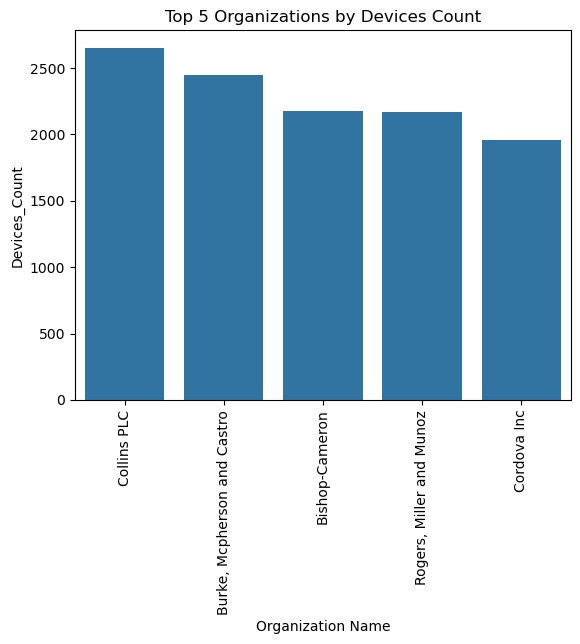

In [94]:
#Get Top 5 Organizations by Device count

organizations_by_devices = (
    total_entities_df.groupby(by = ["organization_id", "org_name"])
    .agg(Devices_Count=("device_id", "nunique"))
    .reset_index()
    .sort_values(by = ['Devices_Count'], ascending=False).head(5)
)
organizations_by_devices.rename(columns = {"org_name":"Organization Name", "organization_id":"Organization Id"}, inplace=True)
organizations_by_devices

sns.barplot(data=organizations_by_devices, y='Devices_Count', x='Organization Name')
plt.xticks(rotation=90)
plt.title('Top 5 Organizations by Devices Count')
plt.show()